In [2]:
import cv2

import os
import sys
import pickle
import random

sys.path.append('../..')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from lib.dataloaders import imread
from lib.datasets import patches_path, wsi_csv_path, patches_clean90_pkl_path, max_lbl_nums

In [3]:
patch_sz = 64

colors = {
    'radboud': {0: '#ffffff',
                1: '#8080ff',
                2: '#80ff80',
                3: '#ff8080',                
                4: '#ff4040',                
                5: '#ff0000'},
    'karolinska': {0: '#ffffff',
                   1: '#808080',
                   2: '#ff0000'},
}

def hex2rgb(h):
    h = h.lstrip('#')
    return [int(h[i:i+2], 16) for i in (0, 2, 4)]

In [4]:
df = pd.read_csv(wsi_csv_path)
with open(patches_clean90_pkl_path, 'rb') as f:
    p_dict = pickle.load(f)

In [5]:
# image_id = '198fa06f052feedc1684e42829c137fc'
image_id = random.choice(list(p_dict.keys()))

In [6]:
image_id = '012f41e5276e881af134c1ae218455cf'

In [7]:
rows = p_dict[image_id]

In [8]:
df[df['image_id'] == image_id]

,image_id,data_provider,isup_grade,gleason_score
47,012f41e5276e881af134c1ae218455cf,karolinska,1,3+3


In [9]:
ys = []
xs = []
for row in rows:
    (_, image_id, data_provider, isup_grade, gleason_score, y, x, *_) = row
    ys.append(y)
    xs.append(x)

In [10]:
min_y, min_x = min(ys), min(xs)
width = max(ys) - min(ys) + 1
height = max(xs) - min(xs) + 1

In [11]:
width, height

(42, 42)

In [12]:
wsi_img = np.full((width*patch_sz, height *patch_sz, 3), (255, 255, 255), dtype=np.uint8)
wsi_img_mask = np.full((width*patch_sz, height *patch_sz, 3), (255, 255, 255), dtype=np.uint8)

for row in tqdm(rows):
    (_, image_id, data_provider, isup_grade, gleason_score, y, x, *_) = row
    fname = f"{image_id}_{y}_{x}"
    p_img = imread(os.path.join(patches_path, f"imgs/{fname}.jpeg"))
    
    r_img = imread(os.path.join(patches_path, f"masks/{fname}.png"))[..., 0]
    m_img = np.zeros_like(p_img)
    for i in range(max_lbl_nums):
        k = r_img == i
        if k.sum() > 0:
            m_img[k] = hex2rgb(colors[data_provider][i])    

    p_img = cv2.resize(p_img, (patch_sz, patch_sz))            
    m_img = cv2.resize(m_img, (patch_sz, patch_sz))
    
    y -= min_y
    x -= min_x
    wsi_img[y*patch_sz:(y+1)*patch_sz, x*patch_sz:(x+1)*patch_sz] = p_img
    wsi_img_mask[y*patch_sz:(y+1)*patch_sz, x*patch_sz:(x+1)*patch_sz] = m_img

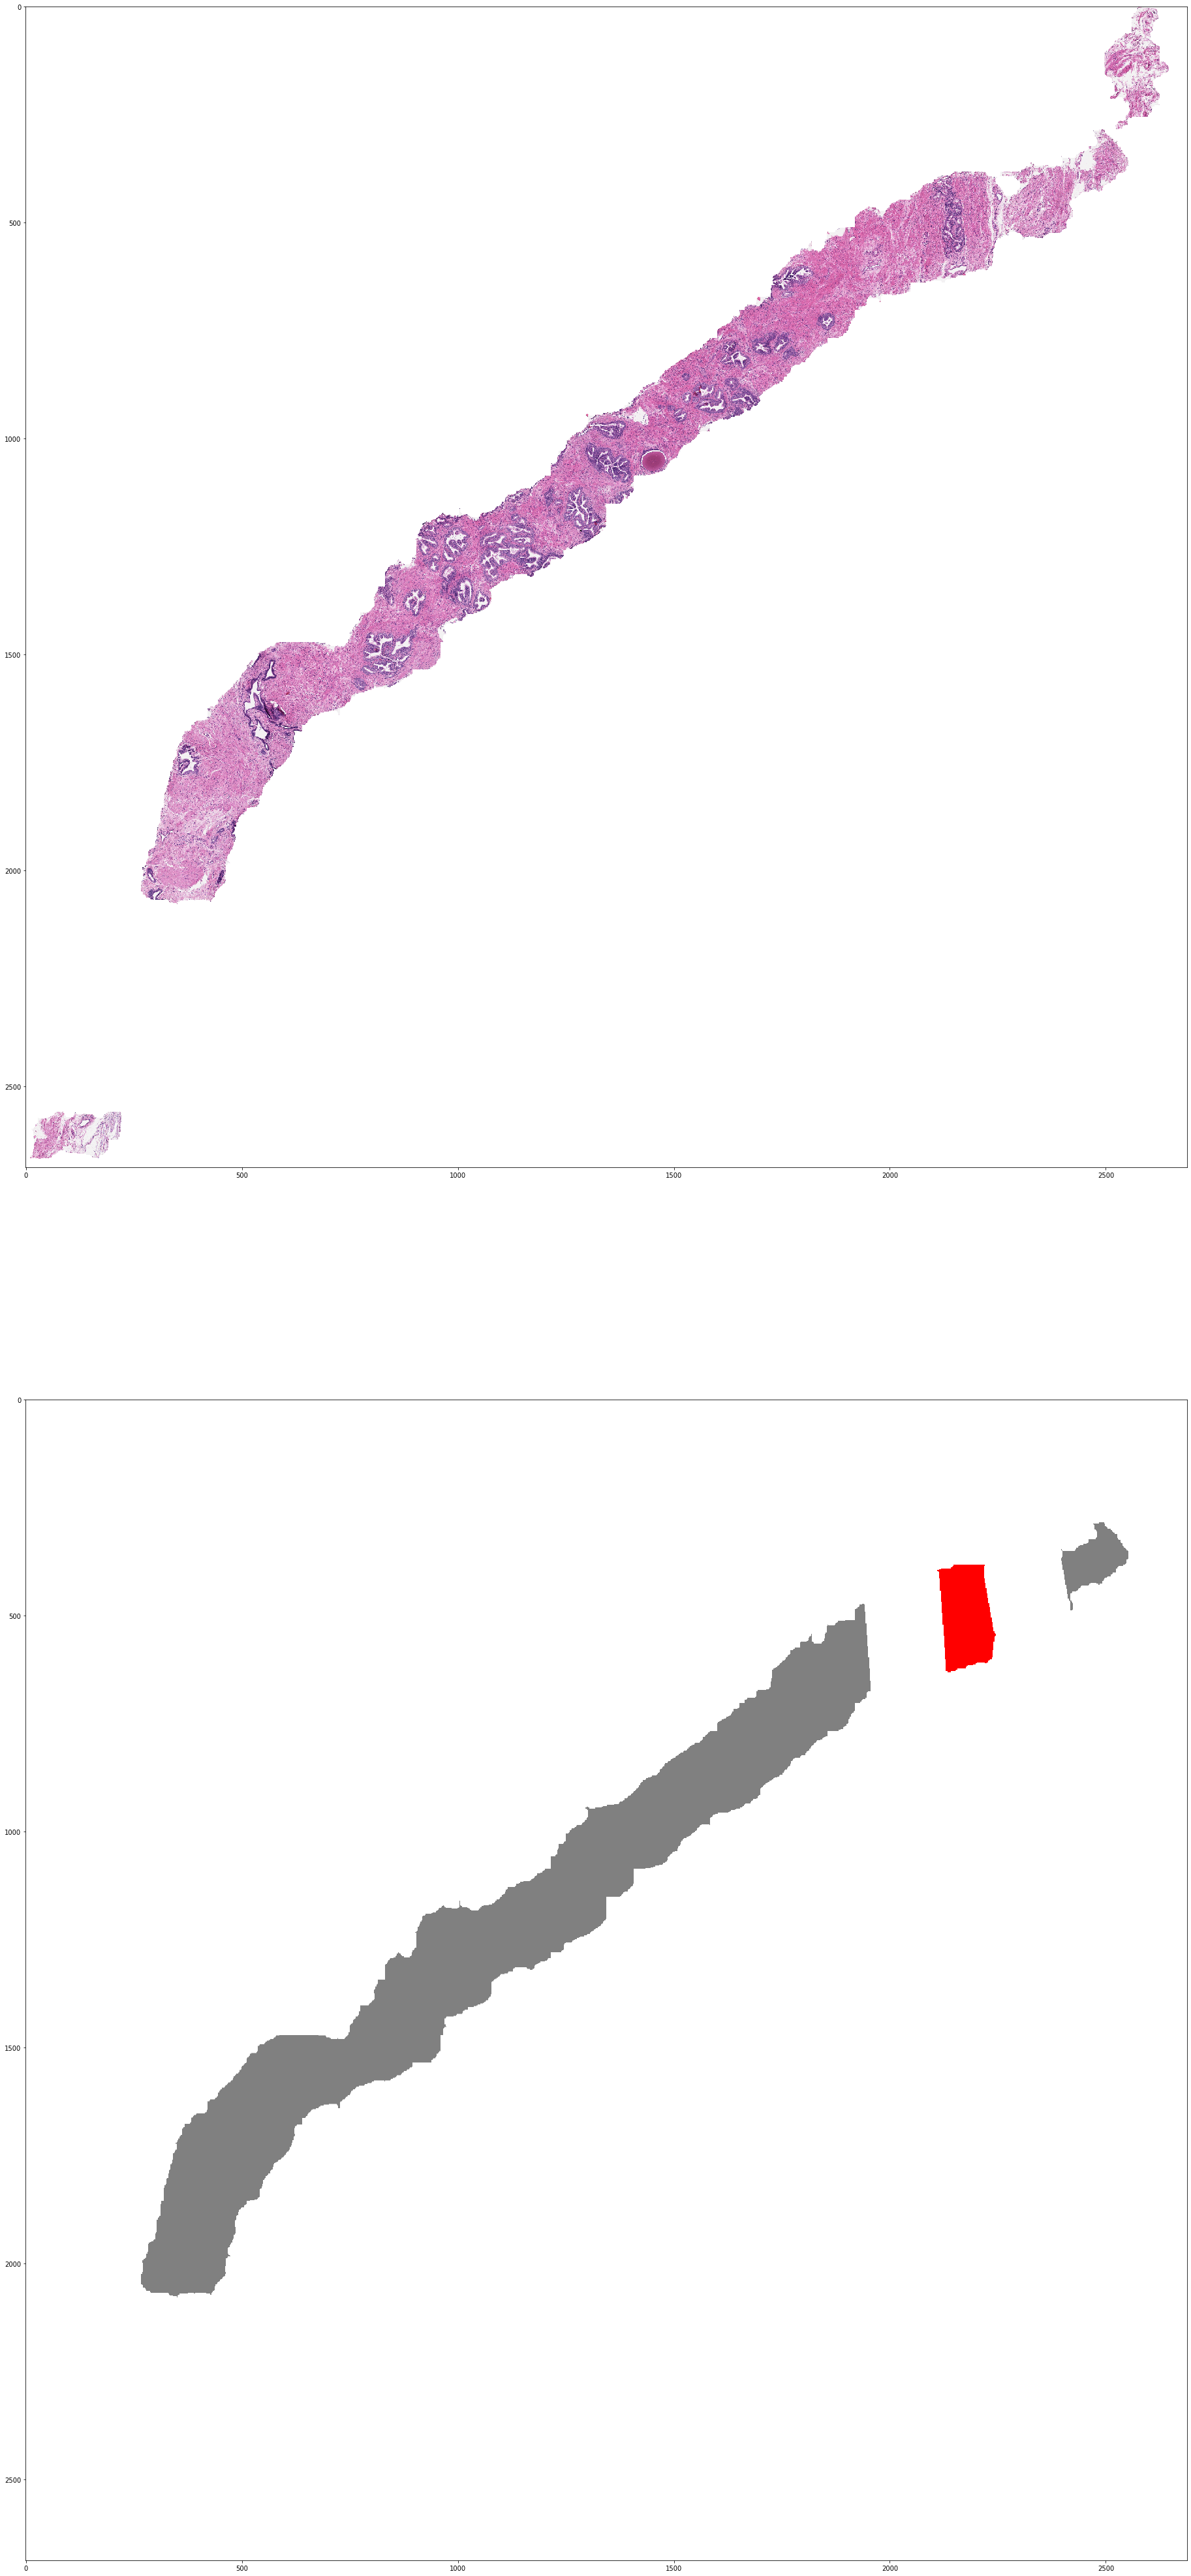

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(36, 72))
axs[0].imshow(wsi_img);
axs[1].imshow(wsi_img_mask);